In [2]:
# importing packages and modules
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

# code from summer project working with PWM data
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

sns.set_context("talk")

In [3]:
# list of animals that have good psychometrics
animalsIDs = ['W060','W068','W073','W074','W075','W080','W081','W082','W088','W089']

In [4]:
pni_path = '/Users/lencacuturela/Desktop/github/LC_PWM_GLM-HMM/data'
laptop_path = '/Users/lencacuturela/Desktop/Research/github/LC_PWM_GLM-HMM/data'

In [4]:
df = io_utils.load_and_wrangle(rat_id='W081', path=None, psychometric=True, cutoff=10, overwrite=False, stage_filter=3)
print(len(df.index.tolist()))
x, y = io_utils.prepare_design_matrices(rat_id='W081', path=None, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W081', path=None, psychometric=True, cutoff=10, stage_filter=3))
print(x.shape)
print(y.shape)
nfolds = 4
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=nfolds, random_state=1)
print(trainX[0].shape)
print(testX[0].shape)
print(len(trainSessInd[0]))

104438
(104438, 6)
(104438,)
(78129, 6)
(26309, 6)
561


In [4]:
x, y = io_utils.prepare_design_matrices(rat_id='W081', path=None, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W081', path=None, psychometric=True, cutoff=10, stage_filter=3))
N = x.shape[0]
print(N)
C = 2 # classes
K = 1 # states
D = x.shape[1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(10**4, K, D), sessInd=sessInd, pi0=None, maxIter=400, tol=1e-4) # fit the model
print(np.argmax(checkLl))

104438
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:491: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities


11


In [11]:
rat_id = 'W081'
path = laptop_path
stage_filter=3
folds=5
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)
D = trainX[0].shape[1]
C = 2 # only looking at binomial classes

fold = 0
N = trainX[fold].shape[0]
oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
trainY[fold] = trainY[fold].astype(int)
testY[fold] = testY[fold].astype(int)

initP, initW = dGLM_HMM.generate_param(sessInd=trainSessInd[fold], transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
allP,  allW, trainLl = dGLM_HMM.fit(trainX[fold], trainY[fold],  initP, initW, sigma=reshapeSigma(10**5, K, D), sessInd=trainSessInd[fold], pi0=None, maxIter=400, tol=1e-3, penaltyW=True) # fit the model

0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:491: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities


KeyboardInterrupt: 

In [7]:
print(dGLM_HMM.observation_probability(trainX[fold],allW).max())

1.0


In [10]:
print(allW.max())
print(allW.min())

133.2098844858166
-53.299640911187204


### Fitting dGLM-HMM1 for PWM data with K=1,2 and multiple sigmas value

In [5]:
randomOrder = np.array([6, 1, 9, 4, 5, 0, 7, 8, 3, 2])
print(randomOrder) # [6 1 9 4 5 0 7 8 3 2]

[6 1 9 4 5 0 7 8 3 2]


In [7]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
nfolds = 4

for randInd in randomOrder:
    animal = animalsIDs[randInd]
    print("Animal ", animal)
    for K in [2]:# [1,2]:
        trainLl, testLl, allP, allW = fit_eval_CV_multiple_sigmas_PWM(rat_id=animal, stage_filter=3, K=K, folds=nfolds, sigmaList = sigmaList, maxiter=200, penaltyW=True, path=laptop_path, save=True)


# new version of obs prob takes ... to fit 

Animal  W081
Sigma Index 0
0
100
Sigma Index 1
0
Animal  W068
Sigma Index 0
0


KeyboardInterrupt: 

In [11]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
nfolds = 4
trainLl, testLl, allP, allW = fit_eval_CV_multiple_sigmas_PWM(rat_id='W081', stage_filter=3, K=2, folds=nfolds, sigmaList = sigmaList, maxiter=300, penaltyW=False, path=laptop_path, save=True)


Sigma Index 0
0
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
100
200
Sigma Index 6
0
100
200
Sigma Index 7
0
100
Sigma Index 8
0
100
200
Sigma Index 9
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:491: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities


100
200
Sigma Index 10
0
100
Sigma Index 11
0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:206: RuntimeWarning: invalid value encountered in true_divide
  alpha[t,:] = pxz/ct[t] # conditional p(z_t | y_1:t)
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:208: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(ct)) # marginal log likelihood p(y_1:T) as sum of log conditionals p(y_t | y_1:t-1)


Sigma Index 12
0


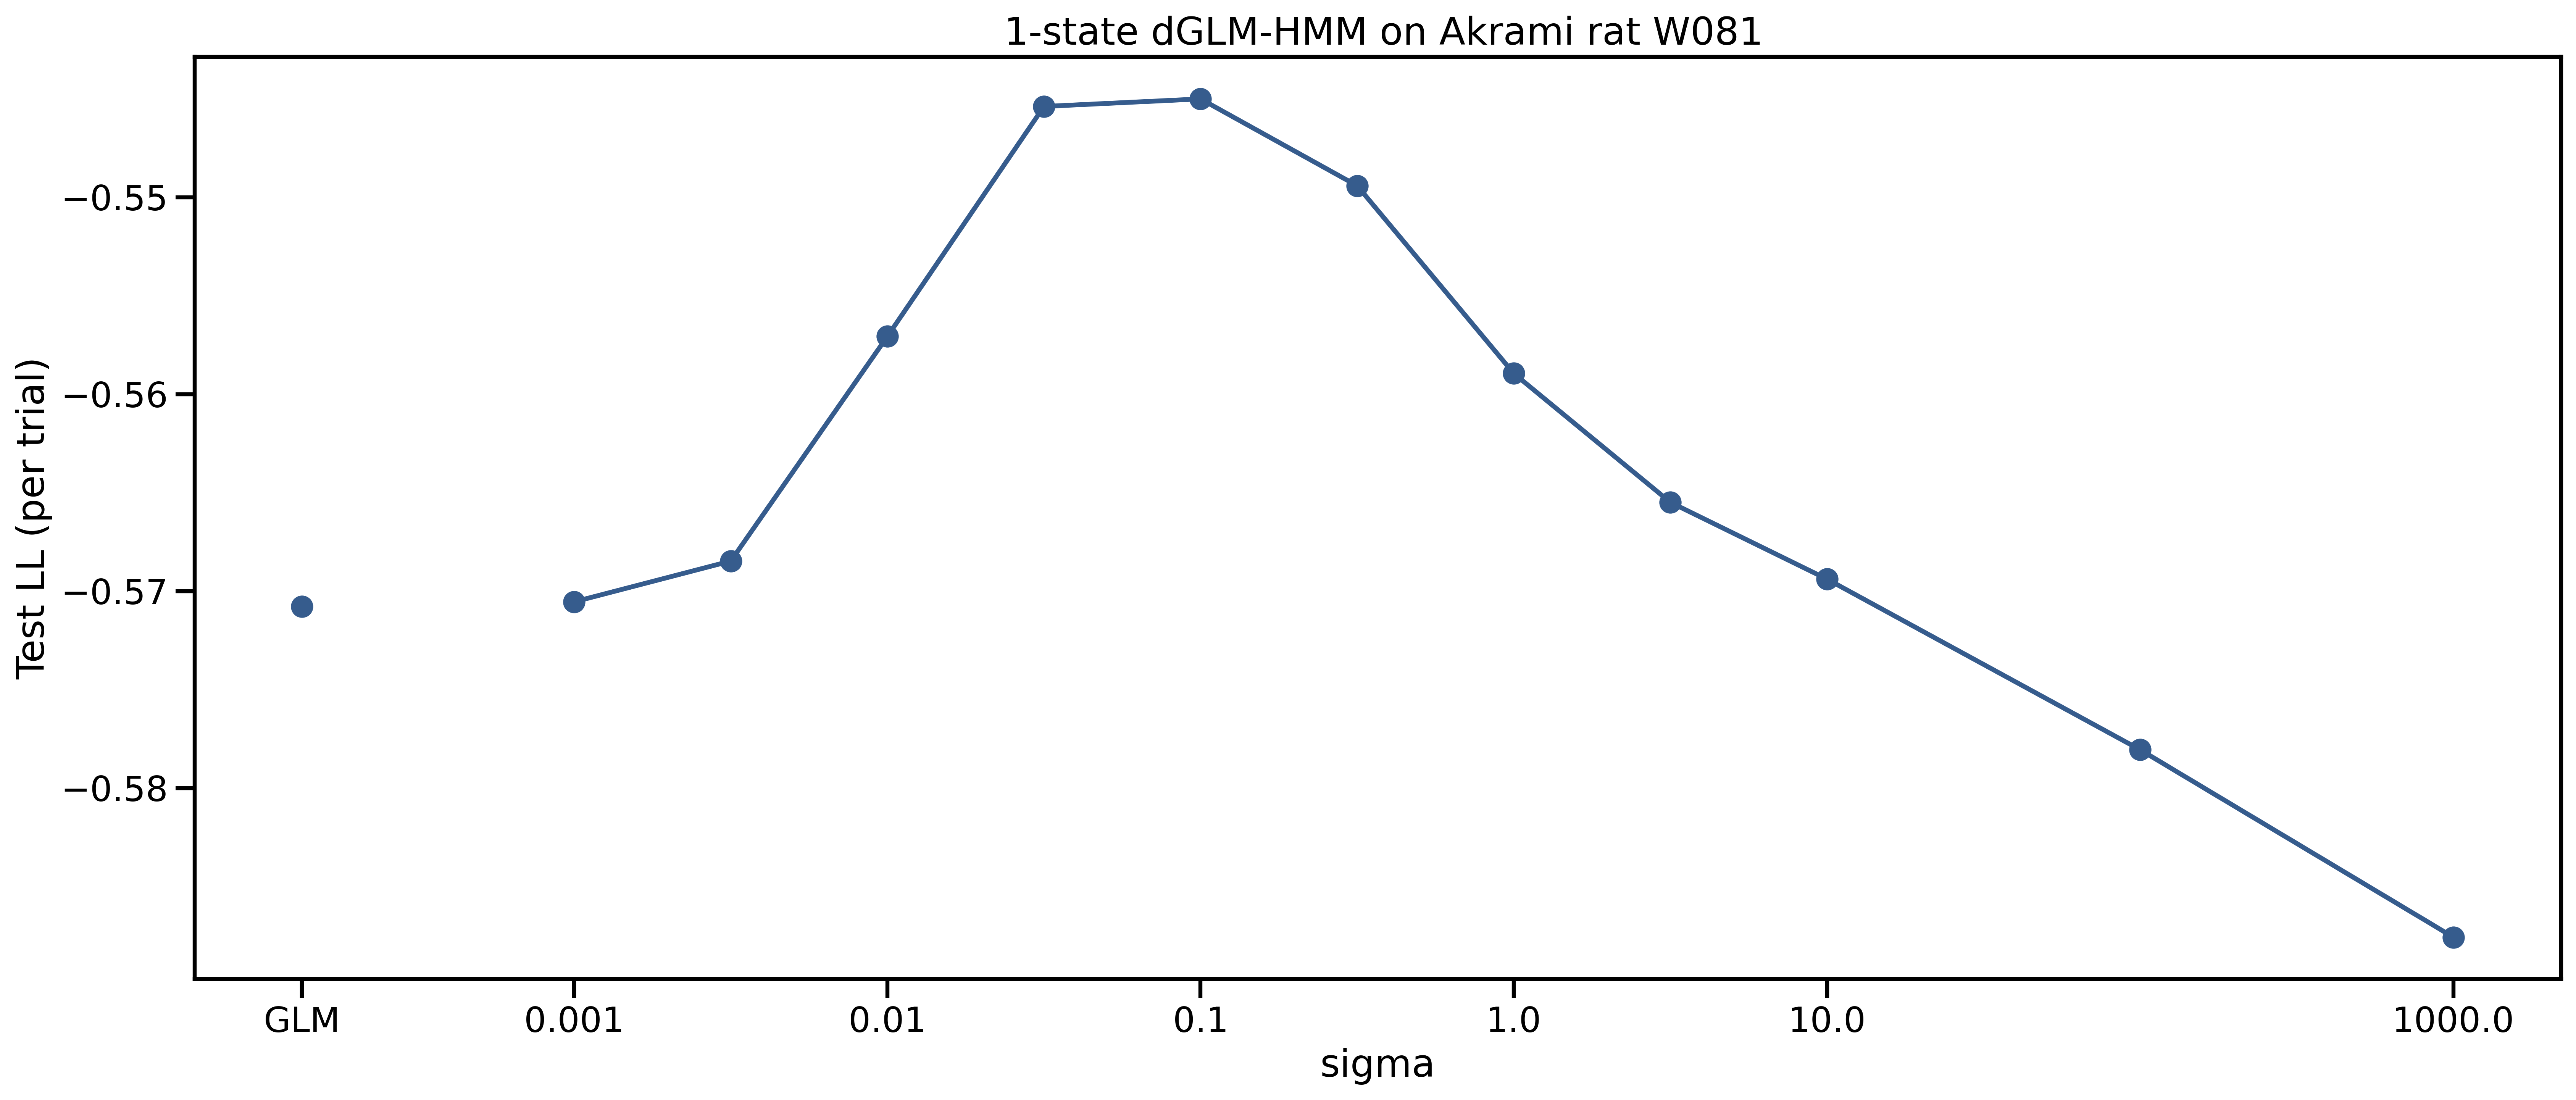

In [6]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))] 
nfolds = 4
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f' 1-state dGLM-HMM on Akrami rat W081', save_fig=True)

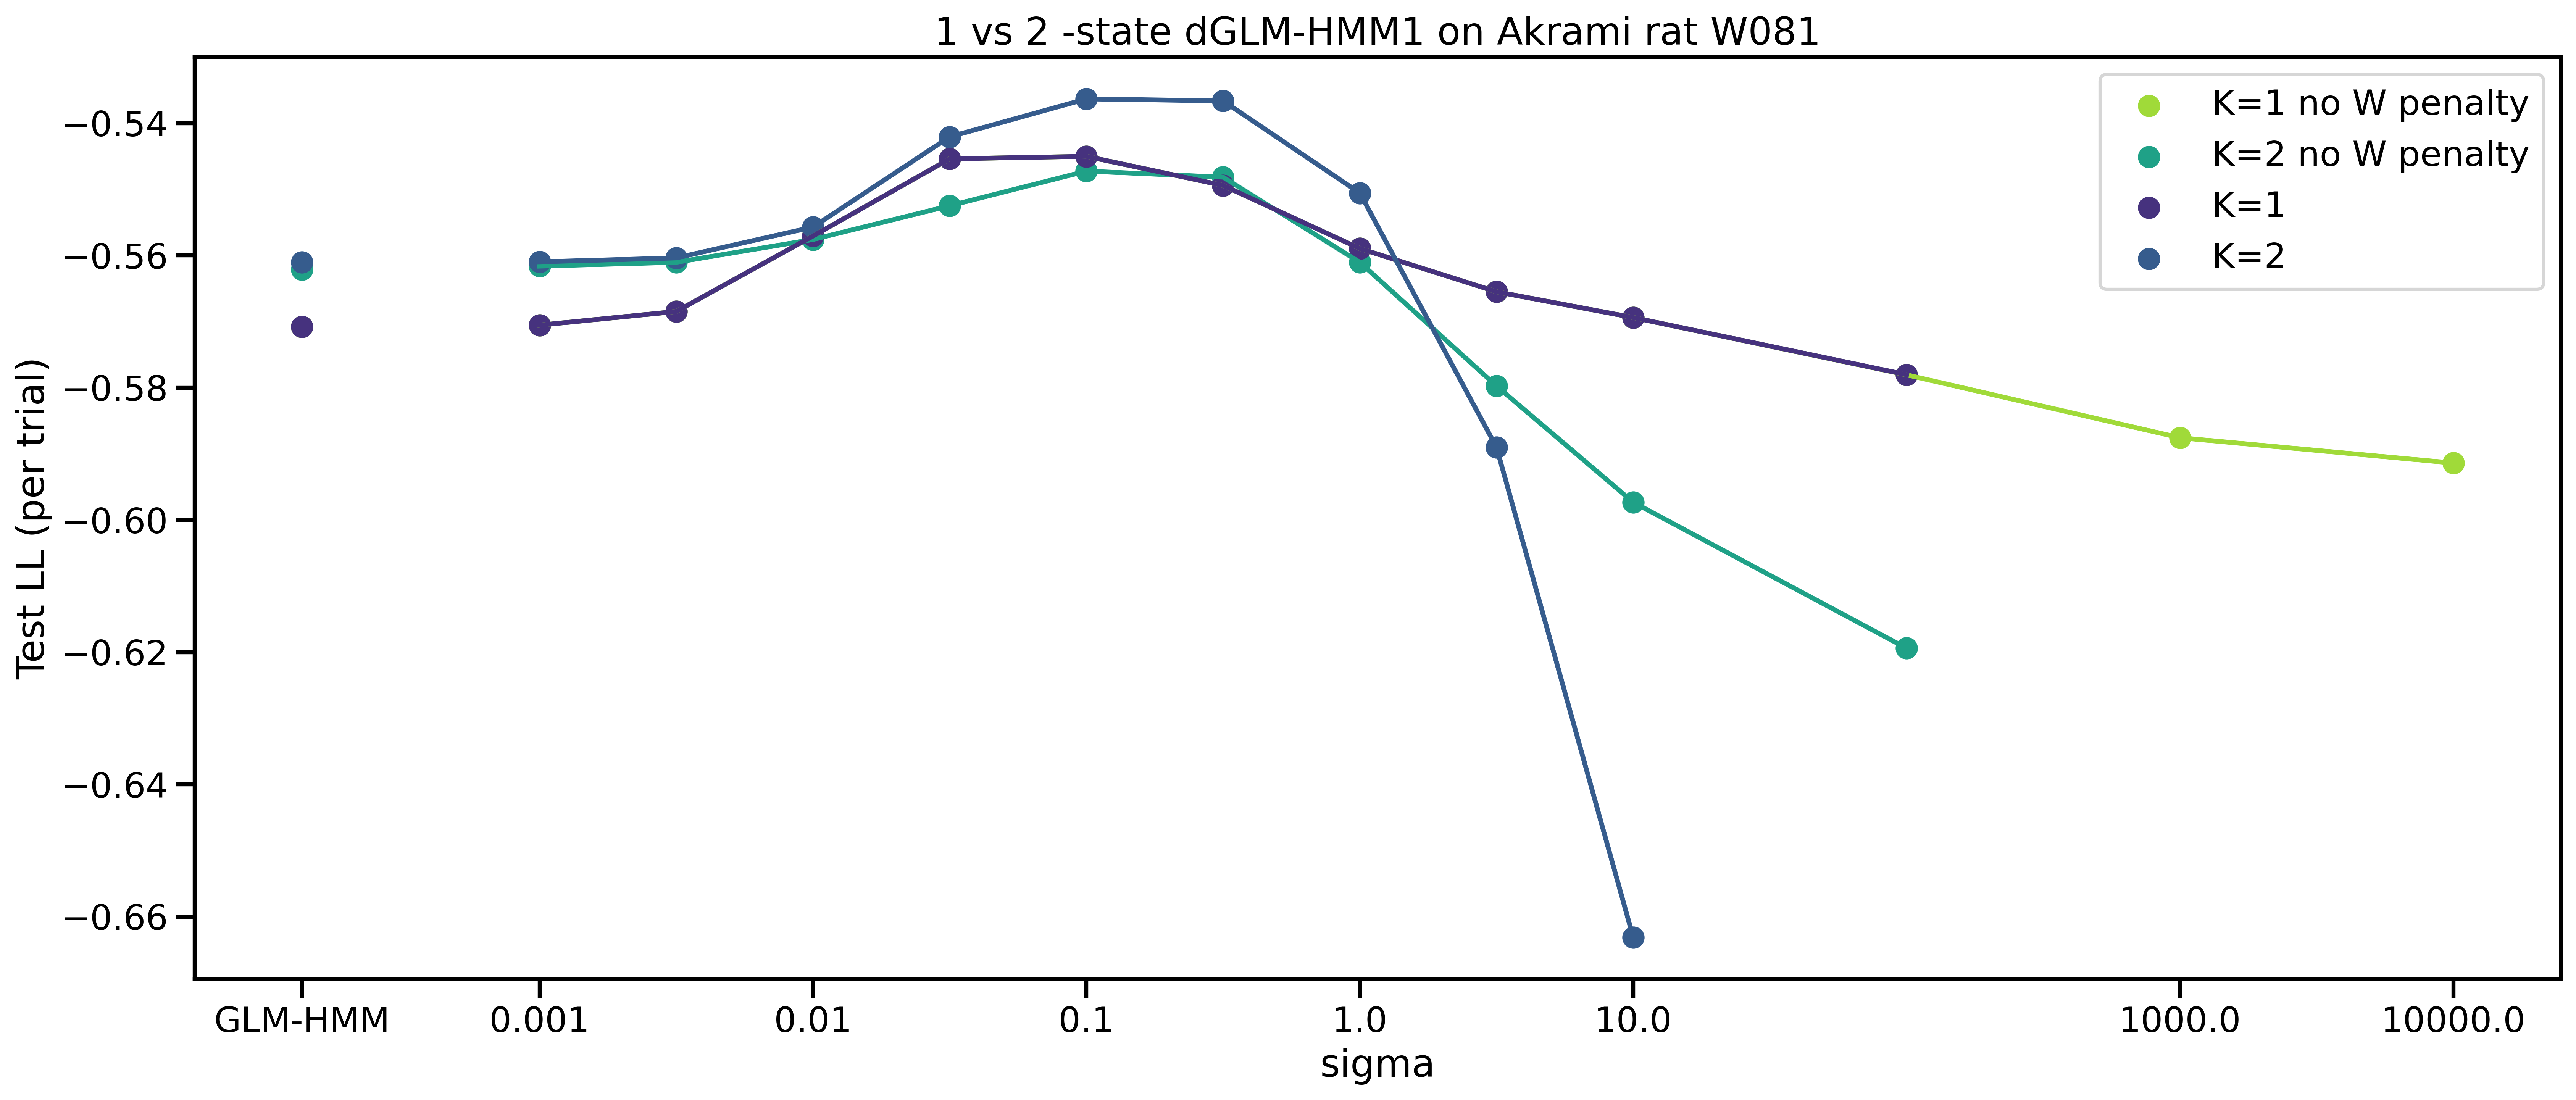

In [15]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W081', labels=['K=1 no W penalty'], color=5, penaltyW=False, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W081', labels=['K=2 no W penalty'], color=3, penaltyW=False, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W081', labels=['K=1'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W081', labels=['K=2'], color=1, penaltyW=True, save_fig=False)